<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/2.1-CNN_1layer-balanced-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Layer CNN - balanced class weight


In [0]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import importlib
import json

import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru



logging.basicConfig(level=logging.INFO)

%matplotlib inline
sns.set()



DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"

DEBUG = False

MODEL_NAME = "CNNB"
ARCHITECTURE = "1"
if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-200k-preprocessed.csv"

directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{MODEL_NAME}-{ARCHITECTURE}-nobatch-{INBASENAME}-sampling_none-{REVIEW_COLUMN}"


# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3
PATIENCE = 4

# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 100
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100

In [0]:
df = pd.read_csv(f"{DATA_FILE}")

In [0]:
df.head()

,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date
0,3,0,0,love polka dot,best quality,2015-08-31
1,5,0,0,five star,very good quality price,2015-08-31
2,5,0,0,case work great fit great very sli,wish bottom top edge little rigid case work gr...,2015-08-31
3,5,0,0,perfect,finished using trip loved able keep tablet ope...,2015-08-31
4,1,0,0,cheaply made,low quality earbuds do not stay ear cheaply made,2015-08-31


In [0]:
rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

**Preprocessing**

In [0]:
# one hot encode ratings
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
print(y.shape)

(199134,)
<class 'pandas.core.series.Series'>
(199134, 5)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:


t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews)


reviews_sequences = t.texts_to_sequences(reviews)
reviews_padded = sequence.pad_sequences(reviews_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


X_train, X_test, y_train, y_test = train_test_split(reviews_padded, y, random_state=1)

Vocabulary size=52523
Number of Documents=199134


# Build our Model

In [0]:
model = Sequential()
model.add(Embedding(len(t.word_counts)+1, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=FILTER1, kernel_size=KERNEL_SIZE, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])


In [0]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          15757200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               400250    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1255      
Total params: 16,187,537
Trainable params: 16,187,537
Non-trainable params: 0
__________________________________________

In [0]:
# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=PATIENCE, 
                              min_lr=0.00001,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')

mw = ku.ModelWrapper(model, MODEL_NAME, LABEL_COLUMN, DATA_FILE, 
                     embedding=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight = weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.43633872 3.07851898 2.18840596 1.19528211 0.3723871 ]
Number of training examples: 149350
Train on 119480 samples, validate on 29870 samples
Epoch 1/100
119480/119480 [==============================] - 241s 2ms/sample - loss: 0.8847 - categorical_accuracy: 0.6576 - val_loss: 0.8183 - val_categorical_accuracy: 0.6802
Epoch 2/100
119480/119480 [==============================] - 234s 2ms/sample - loss: 0.7239 - categorical_accuracy: 0.7148 - val_loss: 0.8179 - val_categorical_accuracy: 0.6815
Epoch 3/100
119480/119480 [==============================] - 219s 2ms/sample - loss: 0.5982 - categorical_accuracy: 0.7673 - val_loss: 0.9005 - val_categorical_accuracy: 0.6701
Epoch 4/100
119480/119480 [==============================] - 219s 2ms/sample - loss: 0.4640 - categorical_accuracy: 0.8231 - val_loss: 1.0619 - val_categorical_accuracy: 0.6470
Epoch 5/100
119480/119480 [==============================] - 220s 2ms/sample - loss: 0.3536 - categorical_accuracy: 0.8696 - val_loss

Number of test: 49784
Running model.evaluate...
49784/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

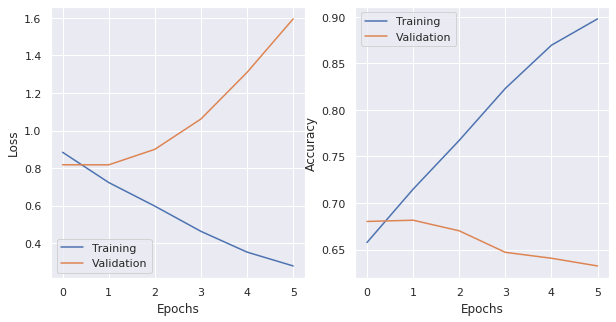


Confusion Matrix
[[ 5530   337   497    92   525]
 [ 1590   315   766   169   385]
 [  877   286  1458   804  1115]
 [  267    96   842  2224  4869]
 [  371    69   446  1456 24398]]

Classification Report
              precision    recall  f1-score   support

           1       0.64      0.79      0.71      6981
           2       0.29      0.10      0.15      3225
           3       0.36      0.32      0.34      4540
           4       0.47      0.27      0.34      8298
           5       0.78      0.91      0.84     26740

    accuracy                           0.68     49784
   macro avg       0.51      0.48      0.48     49784
weighted avg       0.64      0.68      0.65     49784



drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

Overall Score: 0.2547379206932152


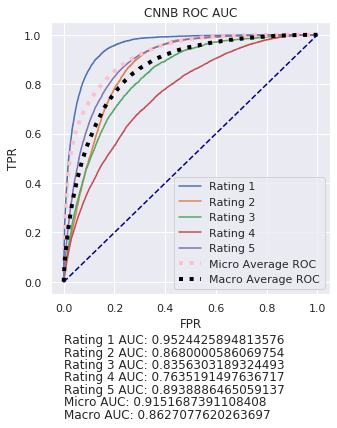

In [0]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))



pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.name, mw.roc_auc, mw.fpr, mw.tpr)

print(f'Overall Score: {ru.calculate_metric(mw.crd)}')

**Save off various files**

In [0]:

mw.save(DRIVE_DIR, append_report=True)


description: amazon_reviews_us_Wireless_v1_00-200k-preprocessed-CNNB-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-200k-preprocessed-CNNB-100-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-200k-preprocessed-CNNB-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-200k-preprocessed-CNNB-100-star_rating-weights.h5


INFO:root:Saving tokenizer file: drive/My Drive/Springboard/capstone/models/dl-tokenizer.pkl


Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [0]:
print(datetime.now())

2019-11-06 04:43:35.632991
